# TDS simulation

Thermo-desorption spectra (TDS) are a valuble source of experimental data for understanding the mechanics of hydorgen transport. The nature of the spectra produced by thermo-desorption experiments can give insight to the trapping properties of a given material. There are three stages in a TDS experiment; The implantation stage, the resting stage and the desoption stage. Each stage can be modelled, and the desportion flux spectra reproduced.

In this task, we'll simulate a thermo-desorption experiment for a sample of tungsten.

In [1]:
import festim as F

my_model = F.HydrogenTransportProblem()

Let's create a mesh from a list of vertices with more refinement close to $x=0$.

In [2]:
import numpy as np

vertices = np.concatenate(
    [
        np.linspace(0, 30e-9, num=200),
        np.linspace(30e-9, 3e-6, num=300),
        np.linspace(3e-6, 20e-6, num=200),
    ]
)

my_model.mesh = F.Mesh1D(vertices)

The material we want to simulate is tungsten. The only property we need is the diffusion coefficient.

In [3]:
tungsten = F.Material(
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 20e-6], material=tungsten)
left_boundary = F.SurfaceSubdomain1D(id=1, x=0)
right_boundary = F.SurfaceSubdomain1D(id=2, x=20e-6)

my_model.subdomains = [
    volume_subdomain,
    left_boundary,
    right_boundary,
]

In [4]:
w_atom_density = 6.3e28  # atom/m3

H = F.Species("H")
trapped_H1 = F.Species("trapped_H1", mobile=False)
trapped_H2 = F.Species("trapped_H2", mobile=False)
empty_trap1 = F.ImplicitSpecies(n=1.3e-3 * w_atom_density, others=[trapped_H1])
empty_trap2 = F.ImplicitSpecies(n=4e-4 * w_atom_density, others=[trapped_H2])
my_model.species = [H, trapped_H1, trapped_H2]

trapping_reaction_1 = F.Reaction(
    reactant=[H, empty_trap1],
    product=[trapped_H1],
    k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=0.39,
    p_0=1e13,
    E_p=0.87,
    volume=volume_subdomain,
)
trapping_reaction_2 = F.Reaction(
    reactant=[H, empty_trap2],
    product=[trapped_H2],
    k_0=4.1e-7 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=0.39,
    p_0=1e13,
    E_p=1.0,
    volume=volume_subdomain,
)

my_model.reactions = [
    trapping_reaction_1,
    trapping_reaction_2,
]

The source term is defined as:
\begin{equation}
    S_{ext} = \varphi \cdot f(x) \quad \forall \, t<400 \text{s}
\end{equation}

where $\varphi =2.5 \times 10^{19} \text{m}^{-2}\text{s}^{-1}$ and $f(x)$ is a Gaussian spatial distribution with a mean value of $4.5 \: \text{nm}$ and a width of $2.5 \: \text{nm}$.

FESTIM has a special class for this case: `ImplantationFlux`.

The ion flux is temporally defined using a Sympy Piecewise expression, to be active for the `implantation_time`.

Below, `t` is a built-in FESTIM variable that represent time in $\text{s}$.

In [5]:
import ufl

implantation_time = 400  # s
incident_flux = 2.5e19  # H/m2/s

ion_flux = lambda t: ufl.conditional(t <= implantation_time, incident_flux, 0)


def gaussian_distribution(x, center, width):
    return (
        1
        / (width * (2 * ufl.pi) ** 0.5)
        * ufl.exp(-0.5 * ((x[0] - center) / width) ** 2)
    )


source_term = F.ParticleSource(
    value=lambda x, t: ion_flux(t) * gaussian_distribution(x, 4.5e-9, 2.5e-9),
    volume=volume_subdomain,
    species=H,
)

my_model.sources = [source_term]

Boundary conditions (BCs) can be of several types in FESTIM, the most simple of them being the `FixedConcentrationBC` where an analytical expression is given in the argument: `value`. The argument `subdomain` is the subdomain on which the BC is applied. If no BC is applied on a surface, it will be considered as a non flux surface (ie $\frac{\partial c}{\partial\textbf{n}} = 0$).

In this case, the solute concentration is set to zero on the left and right surface.

In [6]:
my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=left_boundary, value=0, species=H),
    F.FixedConcentrationBC(subdomain=right_boundary, value=0, species=H),
]

In this example, the temperature is constant from $t=0$ to $t=450 \text{s}$ (implantation + resting phase), then increases from $t=450 \text{s}$ to $t=500 \text{s}$ in order to perform the thermo-desorption (TDS phase).

\begin{equation}
    T(t) =
    \begin{cases}
        300, & \text{if} \: t < 450 \\
        300 + 8(t - 450), & \text{else} \\
    \end{cases}
\end{equation}

$T$ is expressed in $\text{K}$.

In [7]:
implantation_temp = 300  # K
temperature_ramp = 8  # K/s

start_tds = implantation_time + 50  # s


def temp_fun(t):
    if t <= start_tds:
        return implantation_temp
    else:
        return implantation_temp + temperature_ramp * (t - start_tds)


my_model.temperature = temp_fun

In [8]:
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=500)

In [9]:
my_model.settings.stepsize = F.Stepsize(
    initial_value=0.5,
    growth_factor=1.1,
    cutback_factor=0.9,
    target_nb_iterations=4,
    max_stepsize=lambda t: 0.5 if t > start_tds else None,
    milestones=[implantation_time, start_tds],
)

The `Stepsize` object defines the simulation stepsize.

The argument `initial_value` is the initial stepsize is expressed in $\text{s}$.

An adaptive stepsize algorithm has been implemented in order to save computational cost.
`growth_factor` and `cutback_factor` define by how much the stepsize is increased or decreased after each iteration (depending on the number of Newton iterations required to converged).

The optional argument `max_stepsize` sets the maximum stepsize. It takes a function of time. In this case, we cap the stepsize at 0.5 s after the start of the TDS.
We also set `milestones` in order to make sure the simulation doesn't over step the end of the implantation and the start of the TDS.

We want to plot the evolution of the surface fluxes as a function of time.

To do so, we'll use 'derived quantities' objects.
There is a wide range of derived quantities available in FESTIM.

Here, we'll use `TotalVolume` (volume integration) and `HydrogenFlux`.

In [10]:
left_flux = F.SurfaceFlux(surface=left_boundary, field=H)
right_flux = F.SurfaceFlux(surface=right_boundary, field=H)
total_mobile_H = F.TotalVolume(field=H, volume=volume_subdomain)
trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)
trapped_H2 = F.TotalVolume(field=trapped_H2, volume=volume_subdomain)

my_model.exports = [
    total_mobile_H,
    trapped_H1,
    trapped_H2,
    left_flux,
    right_flux,
]

In [11]:
my_model.initialise()
my_model.run()

Solving HydrogenTransportProblem:   0%|          | 0.00/500 [00:00<?, ?it/s]

Solving HydrogenTransportProblem: 100%|██████████| 500/500 [00:05<00:00, 91.7it/s] 


Text(0.5, 0, 'Time (s)')

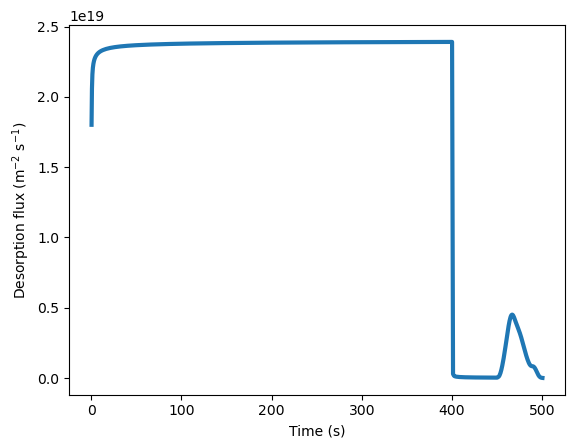

In [12]:
import matplotlib.pyplot as plt

t = left_flux.t
flux_total = np.array(left_flux.data) + np.array(right_flux.data)

plt.plot(t, flux_total, linewidth=3)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

Make use of numpy to compute the time derivative of the traps inventories!

In [13]:
contribution_trap_1 = -np.diff(trapped_H1.data) / np.diff(t)
contribution_trap_2 = -np.diff(trapped_H2.data) / np.diff(t)

We can now plot the TDS spectrum with the 3 traps contributions

Text(0.5, 0, 'Time (s)')

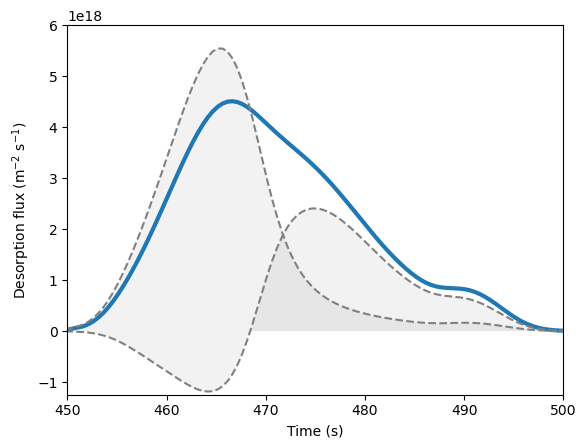

In [14]:
plt.plot(t, flux_total, linewidth=3)
plt.plot(t[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_1, facecolor="grey", alpha=0.1)
plt.plot(t[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_2, facecolor="grey", alpha=0.1)

plt.xlim(450, 500)
plt.ylim(bottom=-1.25e18, top=0.6e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

## Task
1) Increase the implantation temperature to 500 K and see how the TDS spectrum is affected
2) Vary the detrapping energy of the first trap
3) At the end of the implantation phase, what is the proportion of hydrogen trapped in trap 2?

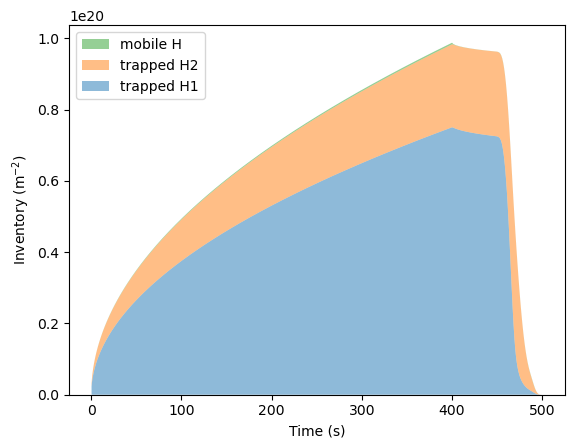

In [15]:
plt.stackplot(
    t,
    trapped_H1.data,
    trapped_H2.data,
    total_mobile_H.data,
    labels=["trapped H1", "trapped H2", "mobile H"],
    alpha=0.5,
)
plt.legend(reverse=True)
plt.ylabel(r"Inventory (m$^{-2}$)")
plt.xlabel(r"Time (s)")
plt.show()